In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from VGG_builder import VGG_builder
from cnn_workflow import utils
from finetuning import *

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm.notebook import tqdm
from tabulate import tabulate
from easydict import EasyDict as edict

%matplotlib inline
import matplotlib.pyplot as  plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [16, 4]

### setup device and vgg type

Use VGG11 network

In [18]:
note = ''

device = utils.get_free_device()
vgg_builder = VGG_builder(num_classes=10, vgg_str='vgg11', classifier_idx=1, model_note=note)

#TODO: train or read
do_training = False

print('vgg classifier: ')
vgg_builder.build().classifier

free GPUs: ['0', '1', '2', '3', '4', '5', '6', '7']
using device: cuda:7
vgg classifier: 


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

# Part 1: standartization of the data

Create dataset and a loader for training and test images

In [4]:
batch_size  = 32
num_workers = 5

train_data = datasets.ImageFolder('data/butterflies/train', transforms.ToTensor())
n_train_data = len(train_data)
test_data = datasets.ImageFolder('data/butterflies/test', transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

Perform standartization of the train and test data: compute mean and standard deviation per color channel over all pixels and all images in the training and test sets.

In [5]:
train_mean, train_std = utils.mean_std(train_loader)
print(f'train data mean per channel: {train_mean}')
print(f'train data std per channel: {train_std}')

test_mean, test_std = utils.mean_std(test_loader)
print(f'test data mean per channel: {test_mean}')
print(f'test data std per channel: {test_std}')

train data mean per channel: tensor([0.4631, 0.4483, 0.3237])
train data std per channel: tensor([0.2828, 0.2648, 0.2752])
test data mean per channel: tensor([0.4548, 0.4413, 0.3095])
test data std per channel: tensor([0.2846, 0.2691, 0.2695])


In [6]:
train_data_standardized = datasets.ImageFolder('data/butterflies/train', transform=transforms.Compose([ transforms.ToTensor() , transforms.Normalize(train_mean, train_std)]))
test_data_standardized = datasets.ImageFolder('data/butterflies/test', transform=transforms.Compose([ transforms.ToTensor() , transforms.Normalize(test_mean, test_std)]))

Split the normalized training data into train and validation subsets with fraction of validation data `val_fraction`.  Create loaders for train, validation and test standardized data.

In [7]:
val_fraction=0.2
split_index = int(val_fraction*n_train_data)
val_indices, train_indices = torch.randperm(n_train_data).tensor_split([split_index])

train_loader_standardized = torch.utils.data.DataLoader(train_data_standardized, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices), num_workers = num_workers, pin_memory=True)
val_loader_standardized = torch.utils.data.DataLoader(train_data_standardized, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_indices), num_workers = num_workers, pin_memory=True)
test_loader_standardized = torch.utils.data.DataLoader(test_data_standardized, batch_size=batch_size, num_workers = num_workers, pin_memory=True)

data_loader = edict({'train_loader': train_loader_standardized, 'val_loader':val_loader_standardized, 'test_loader': test_loader_standardized})
print(f"#train samples: {n_train_data - split_index}")
print(f"#validation samples: {split_index}")
print(f"#test samples: {len(test_data)}")

#train samples: 546
#validation samples: 136
#test samples: 150


# Part 2 : feature extraction

Using `VGG_builder` (see finetuning.py) load vgg11 model, freeze all parameters, redefine its classifier.

Train the network with:
- frozen features
- learning rates 0.1, 0.01, 0.001, 0.0001
- Adadelta optimizer with selected learning rate, other parameters are default.

In [8]:
phase = 'feature extraction phase 1'
vgg_builder.set_freeze_features(True)
lrs = [.1, .01, .001, .0001]
results_fe = lr_test(device, data_loader, epoch_num=5, lrs=lrs, vgg_builder=vgg_builder, note=phase, save_epochs=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Select learning rate with lowest training loss

selected lr 0.1 with training loss 0.00134 at epoch 5


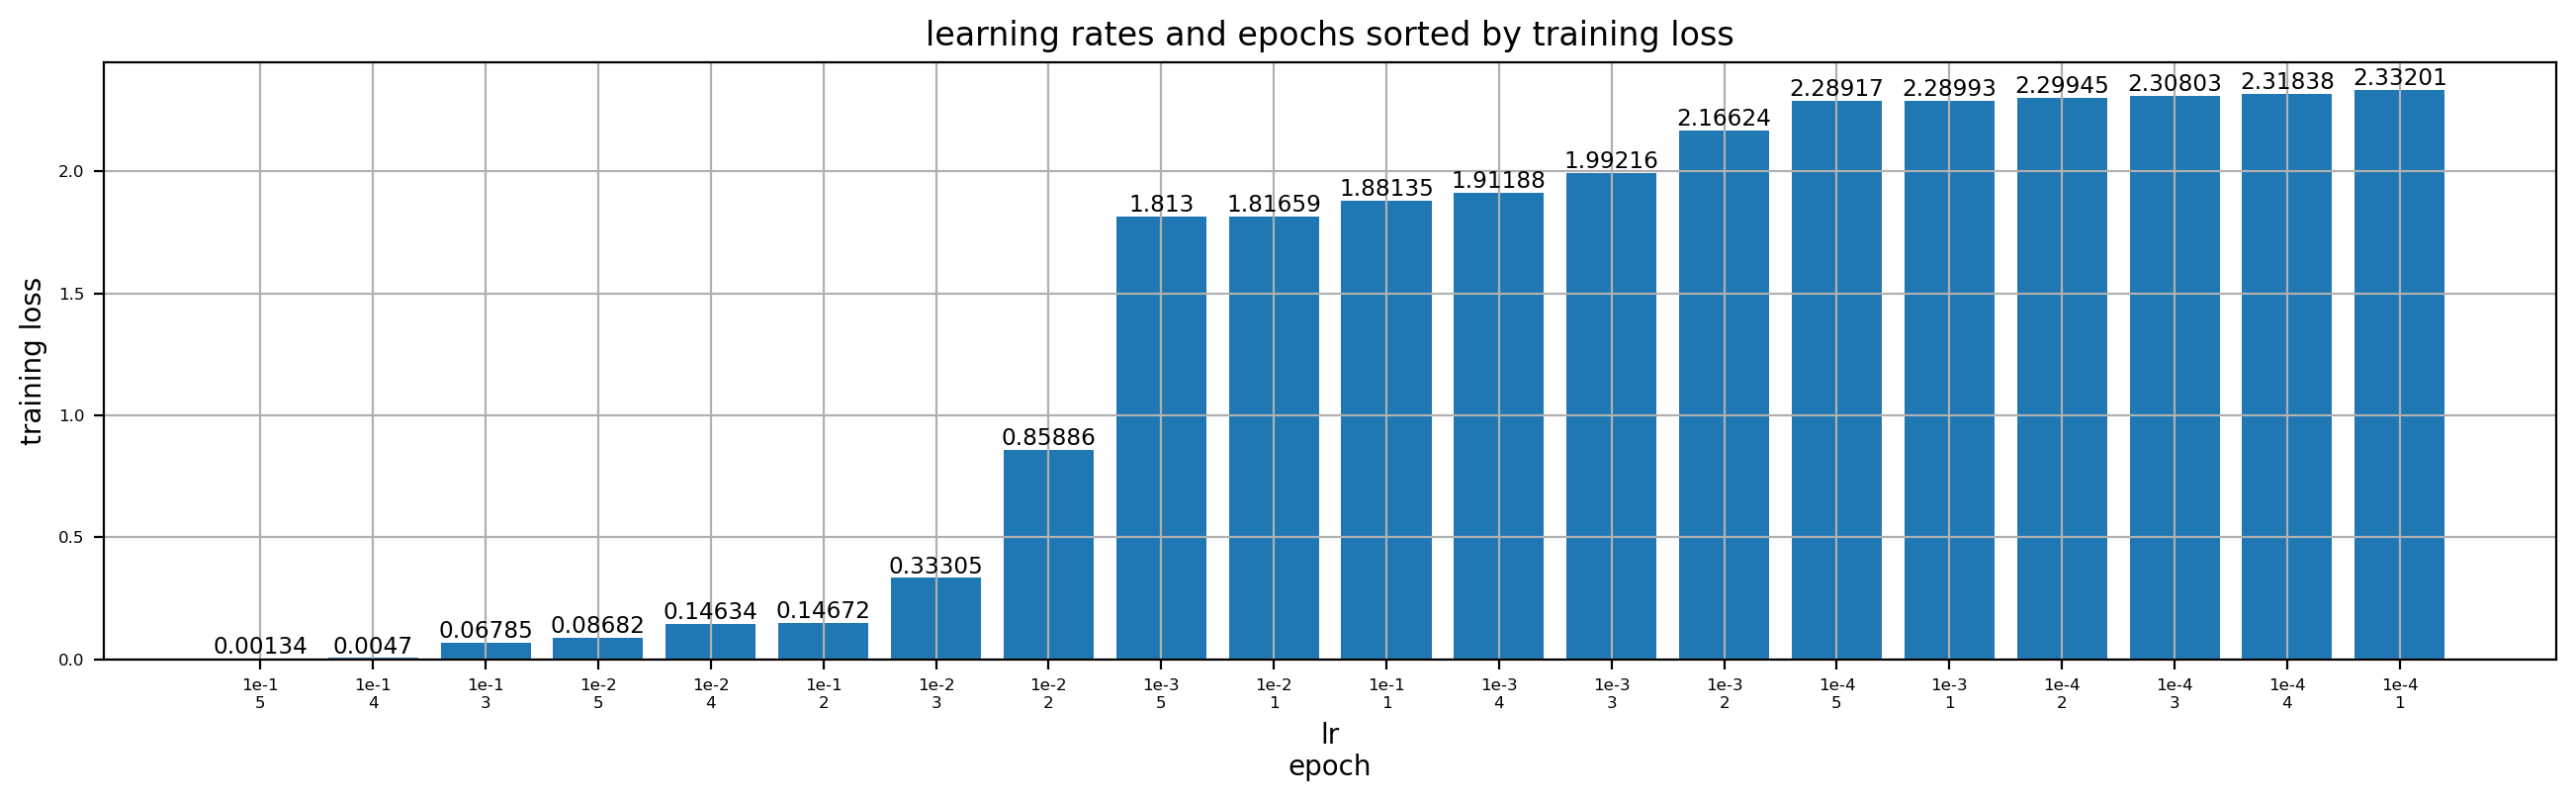

In [9]:
best_lr = utils.select_best_lr(results_fe, lrs, based_on = 'trn_loss', descending = False)

Select 5 learning rate values around the best learning rate, train networks for 20 epochs for each learning rate.

In [10]:
phase = 'feature extraction phase 2'
lrs2 = utils.lrs_near_given(best_lr)
results_fe2 = lr_test(device, data_loader, epoch_num=20, lrs=lrs2, vgg_builder=vgg_builder, note=phase,save_epochs=True)

Created dir: runs/2022_04_29 20_51_45 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 20_53_50 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.3


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 20_55_55 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 20_58_23 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.075


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 21_01_02 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.05


  0%|          | 0/20 [00:00<?, ?it/s]

Show the results of training.

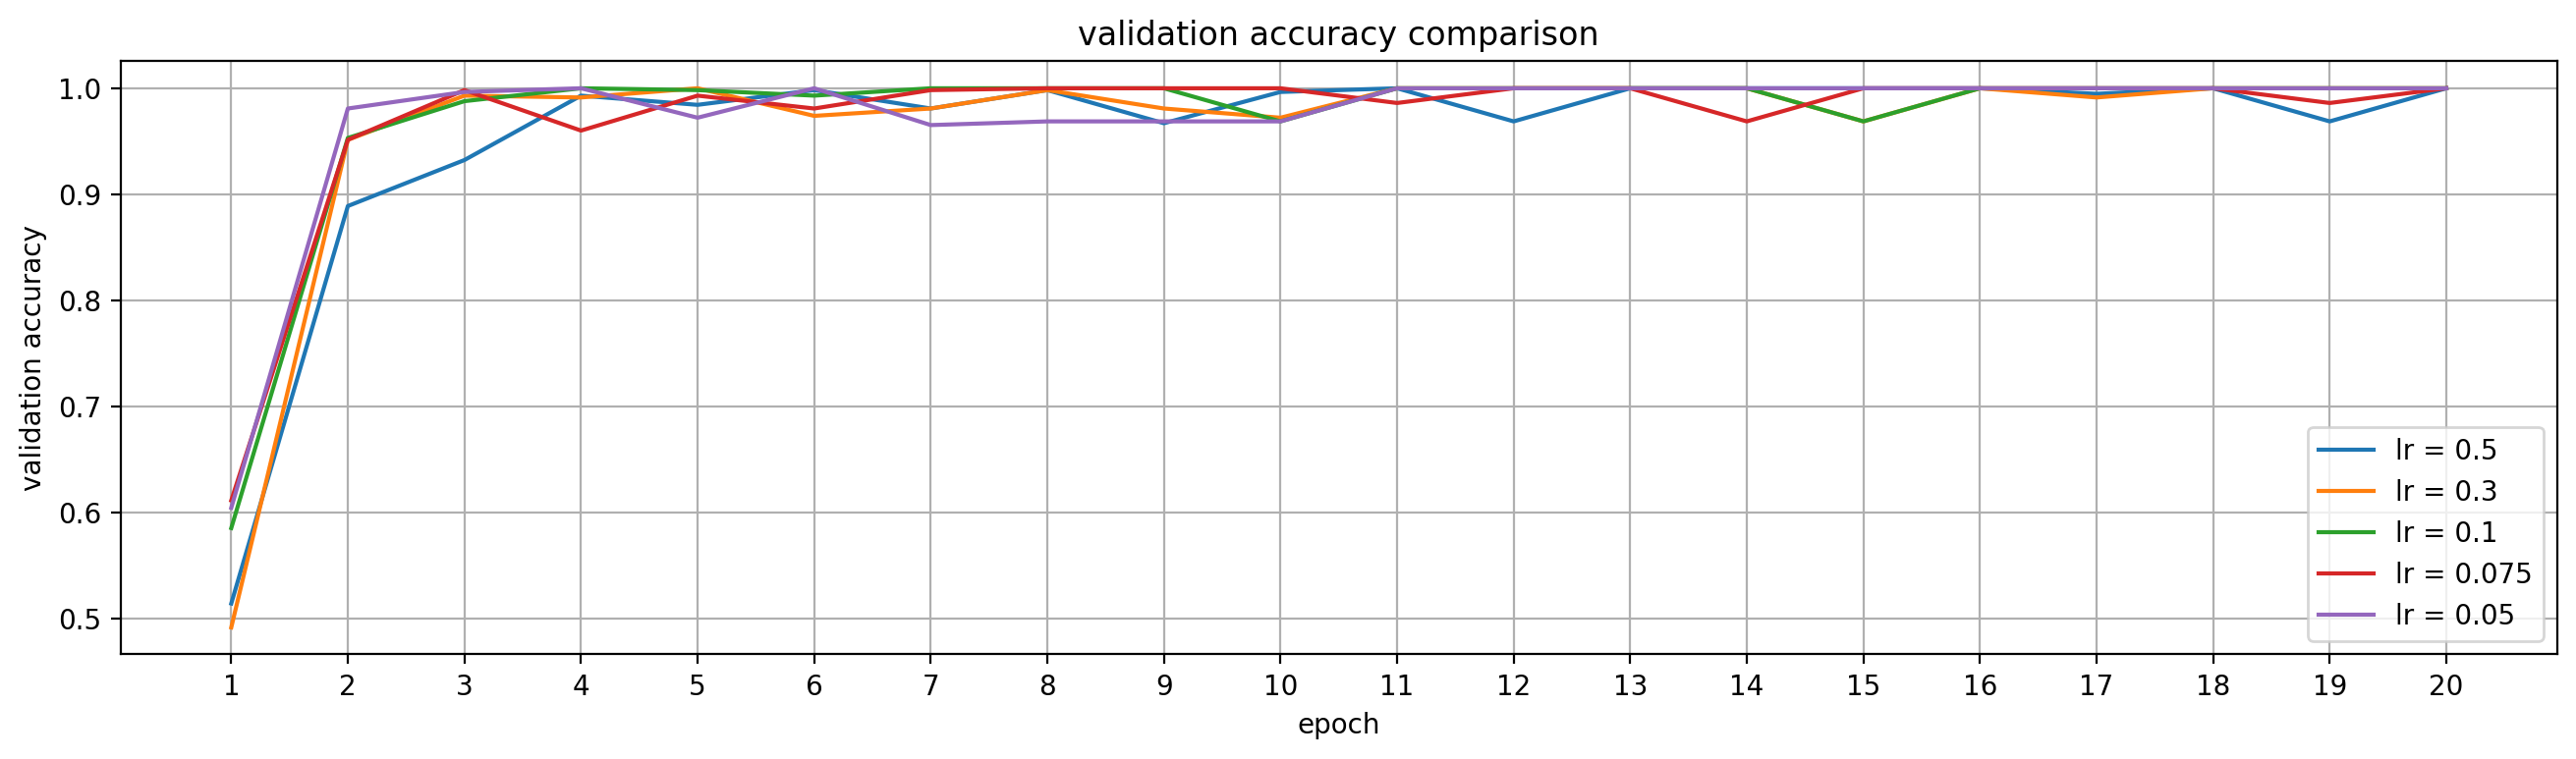

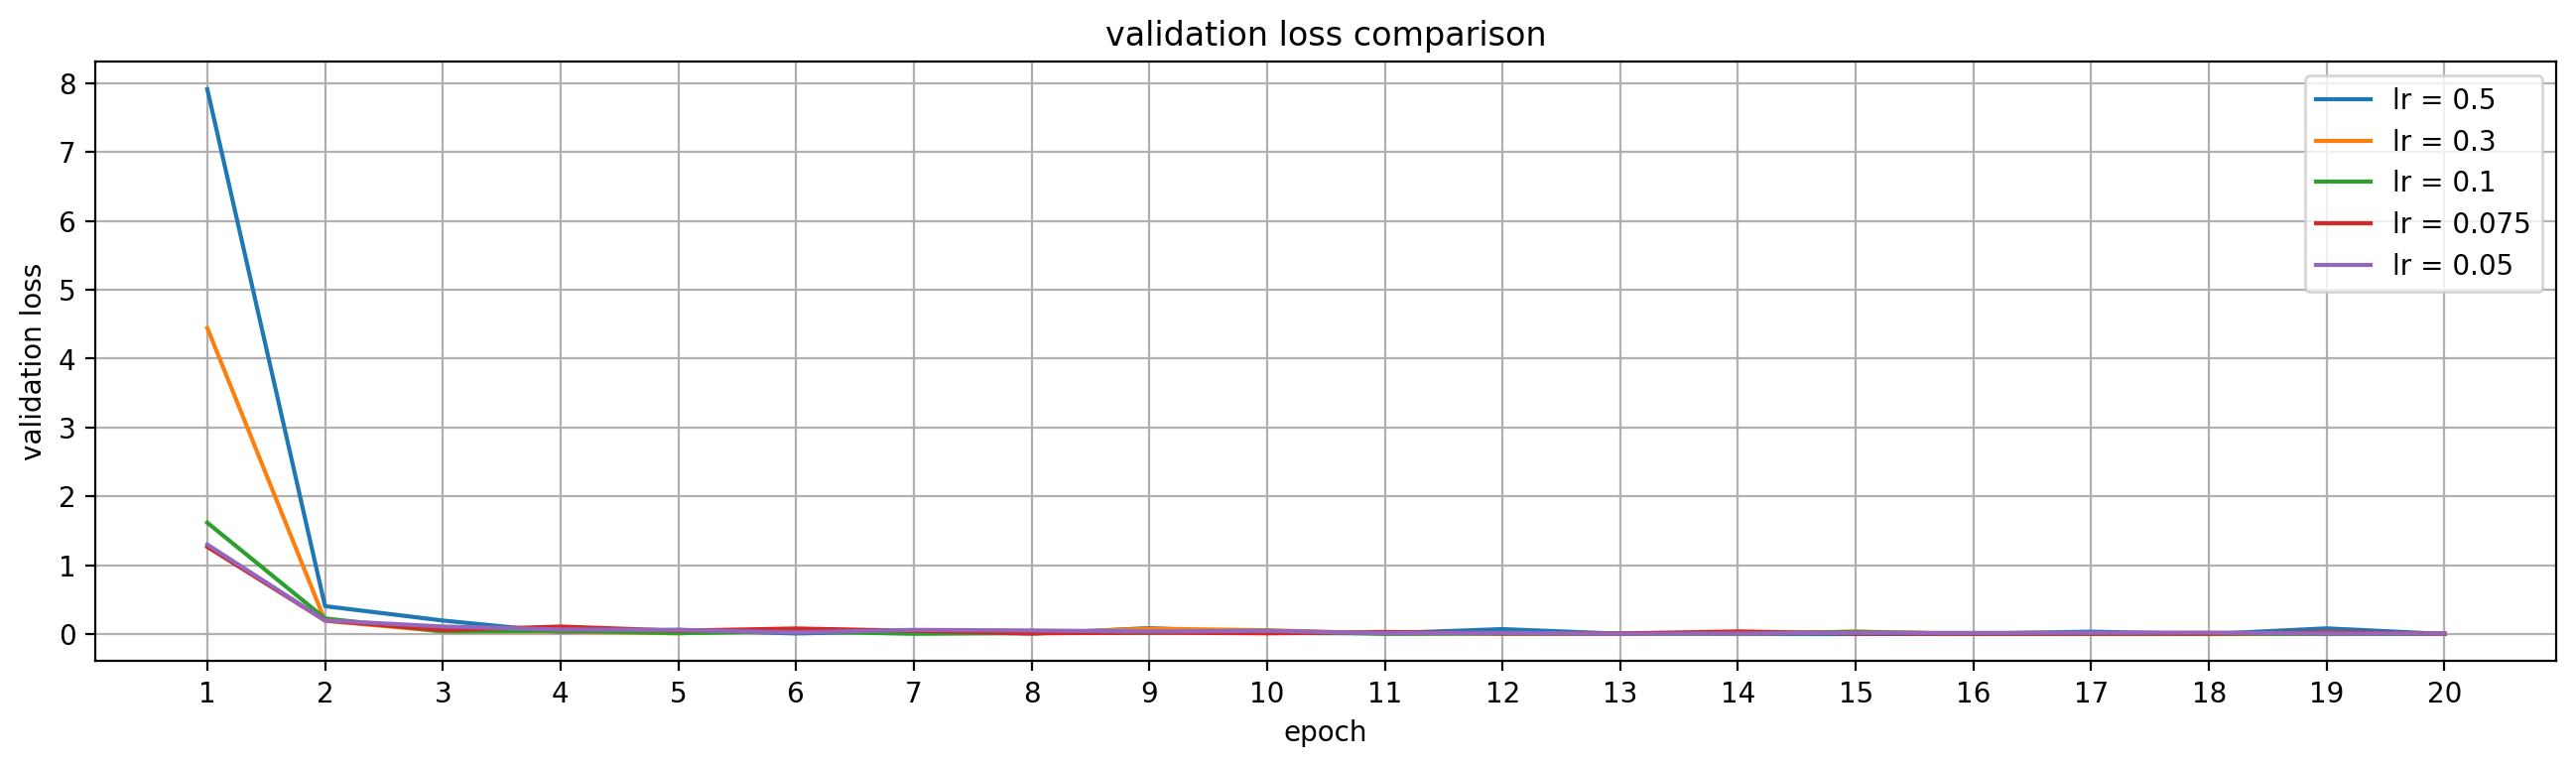

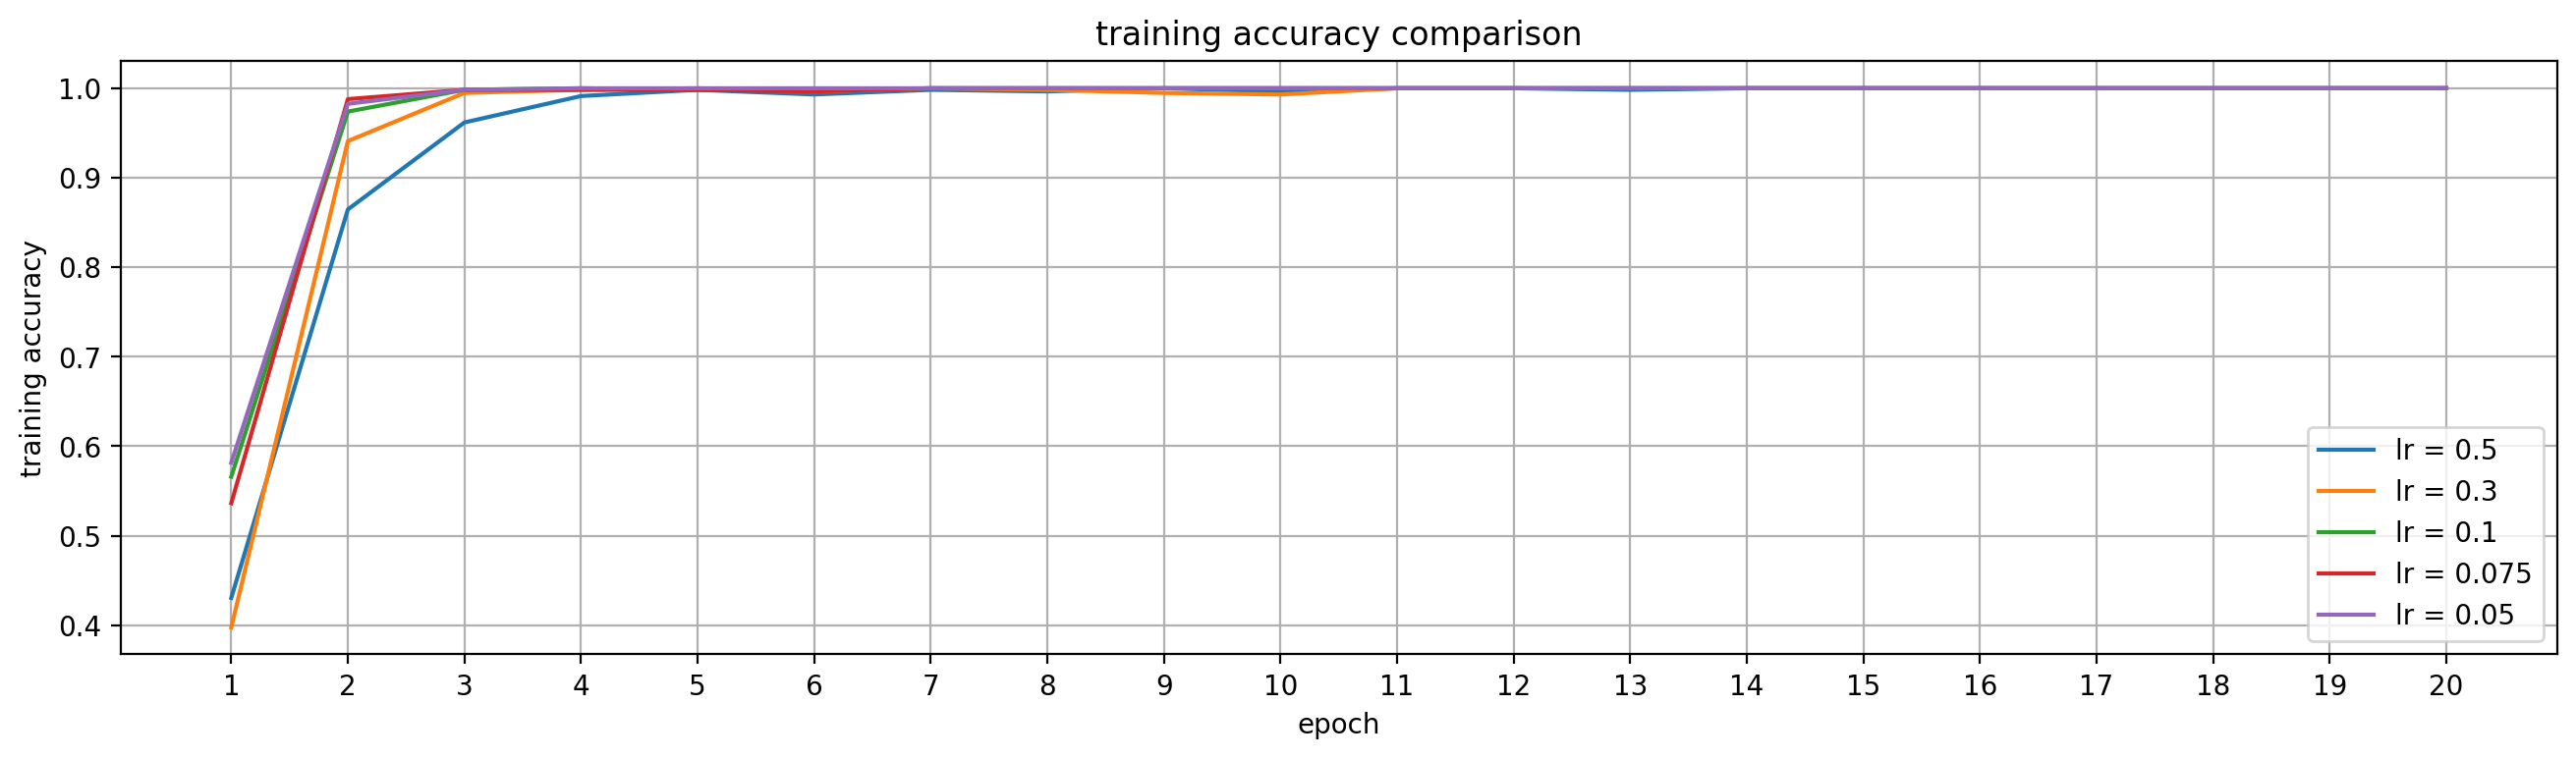

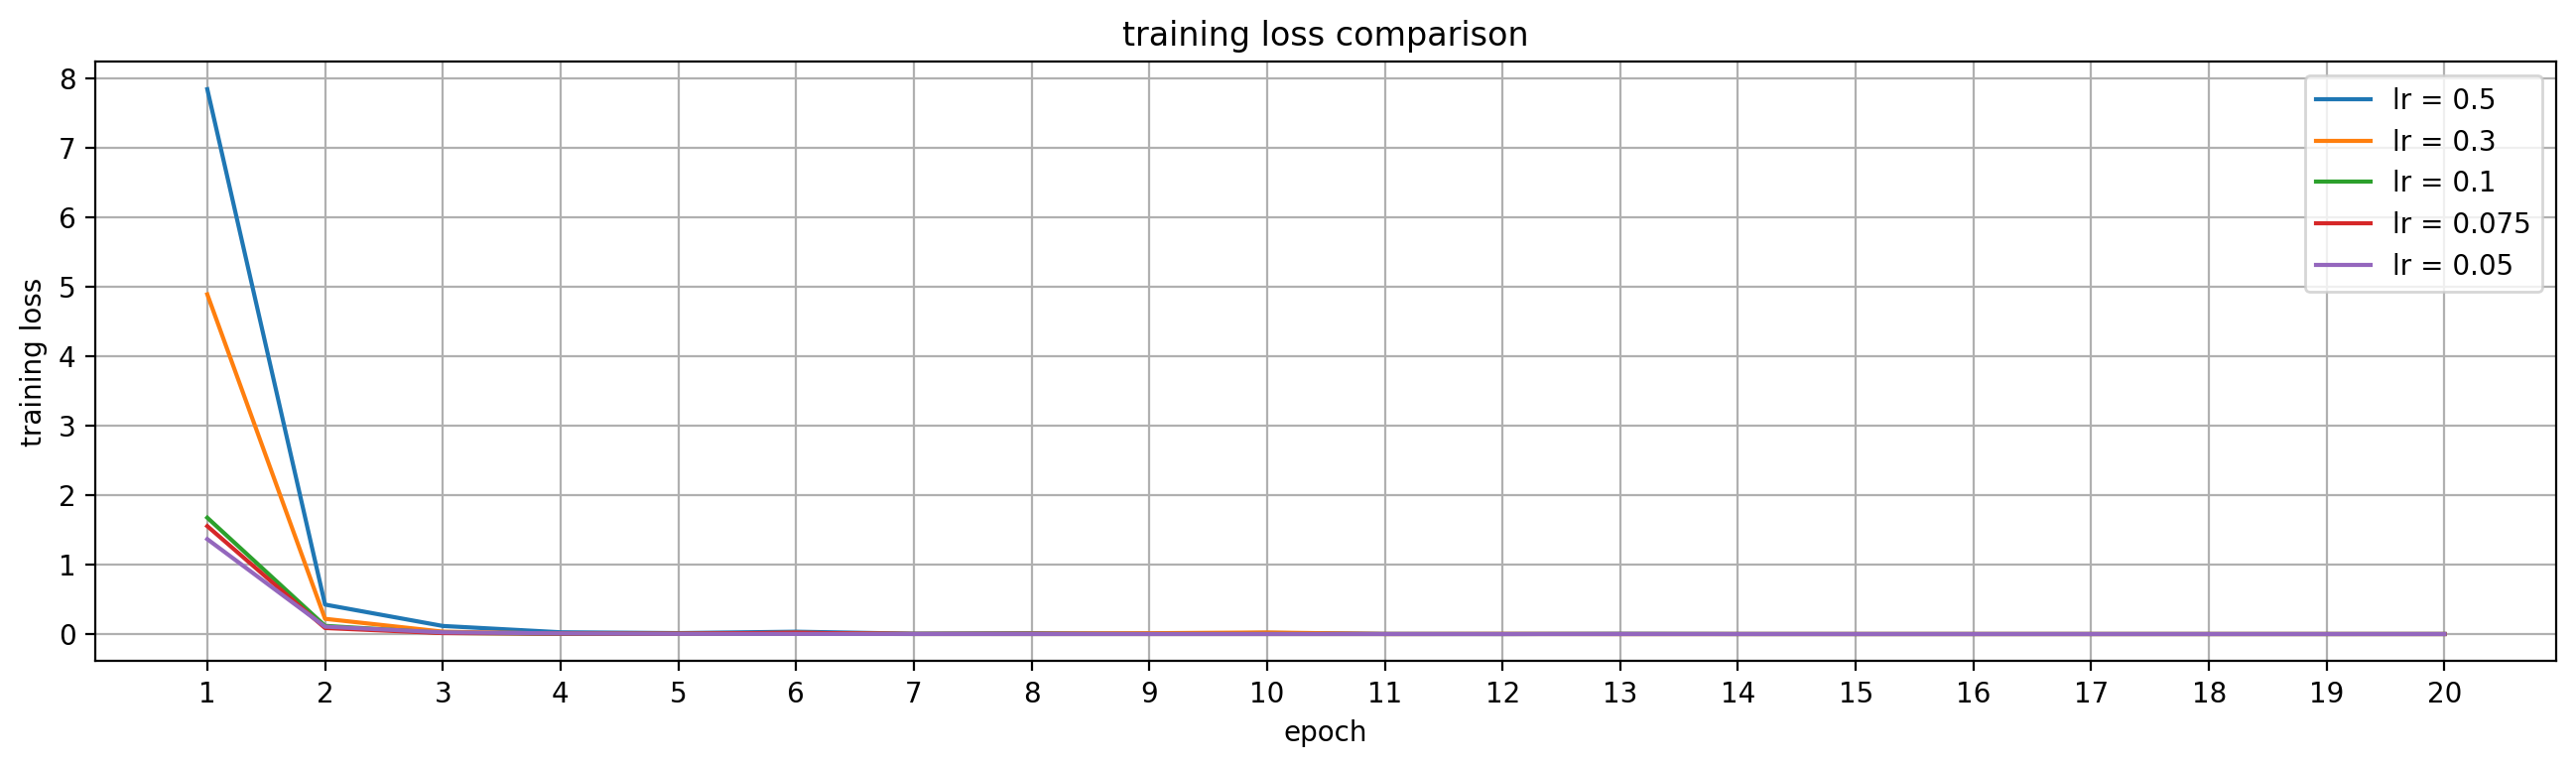

In [11]:
utils.display_results_compare(results_fe2, utils.lrs_to_str(lrs2))

Sort all epochs by validation accuracy and validation loss, and show test results of the first 10.

In [12]:
filter_list = [phase, vgg_builder.classifier_str(), note]
test_results,headers = get_test_results(filter_list, data_loader, device, vgg_builder, first_n=10)

print(tabulate(test_results, headers=headers))

51/100 has validation accuracy >= 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

  #    lr    epoch     val loss    val acc    test loss    test acc  model path
---  ----  -------  -----------  ---------  -----------  ----------  -------------------------------------------------------------------------------------------------------
  1   0.5       15  1.67636e-06          1    0.0551059    0.978409  runs/2022_04_29 20_51_45 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.5/models/VGG_15.pt
  2   0.3       19  0.000169967          1    0.0808534    0.978409  runs/2022_04_29 20_53_50 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.3/models/VGG_19.pt
  3   0.1       19  0.000206961          1    0.05771      0.978409  runs/2022_04_29 20_55_55 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.1/models/VGG_19.pt
  4   0.5       14  0.000296828          1    0.0468986    0.99375   runs/2022_04_29 20_51_45 VGG vgg11 classifier 1 feature extraction phase 2 e=20 lr=0.5/models/VGG_14.pt
  5   0.3       20  0.000320649          1    0.0847158

Show misclassified test images

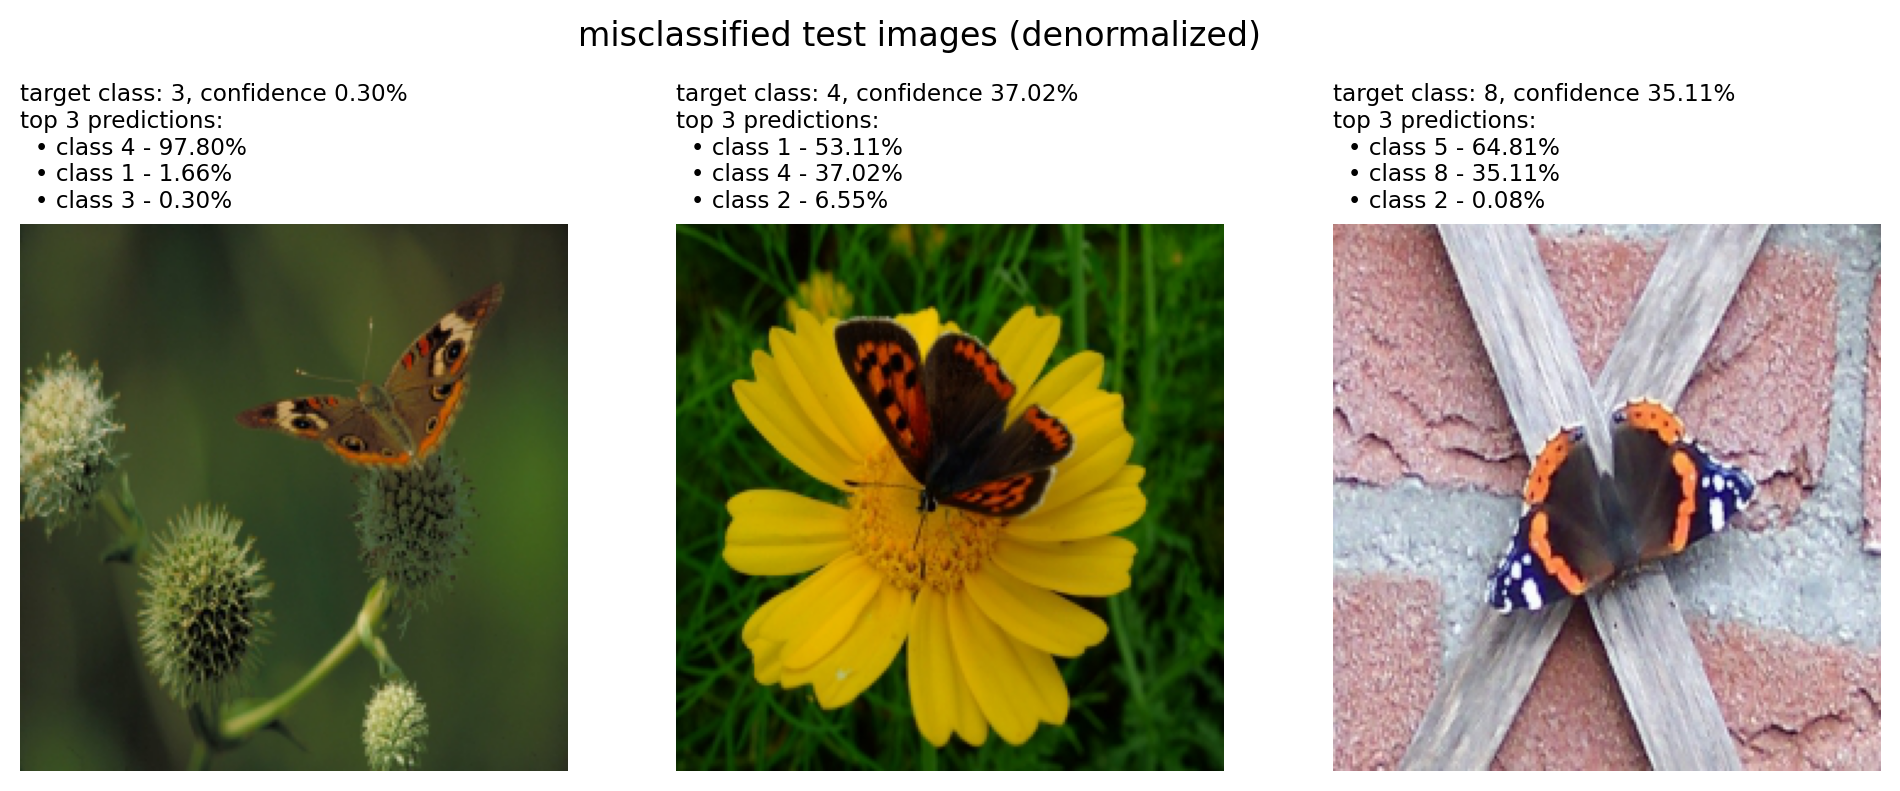

In [13]:
model = vgg_builder.build().to(device)
utils.load_state_to_network(device,test_results[0][-1],model)
utils.show_misclassified(model, device, data_loader.test_loader, test_mean, test_std, save_path='test_results/'+' '.join(filter_list))

# Part 3: finetuning

Finetune the whole model: Repeat Part 1 without freezing the model parameters.

In [14]:
phase = 'finetuning phase 1'
lrs = [.1, .01, .001, .0001]
vgg_builder.set_freeze_features(False)
results_ft = lr_test(device, data_loader, epoch_num=5, lrs=lrs, vgg_builder=vgg_builder, note = phase,save_epochs=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

selected lr 0.01 with training loss 0.00762 at epoch 5


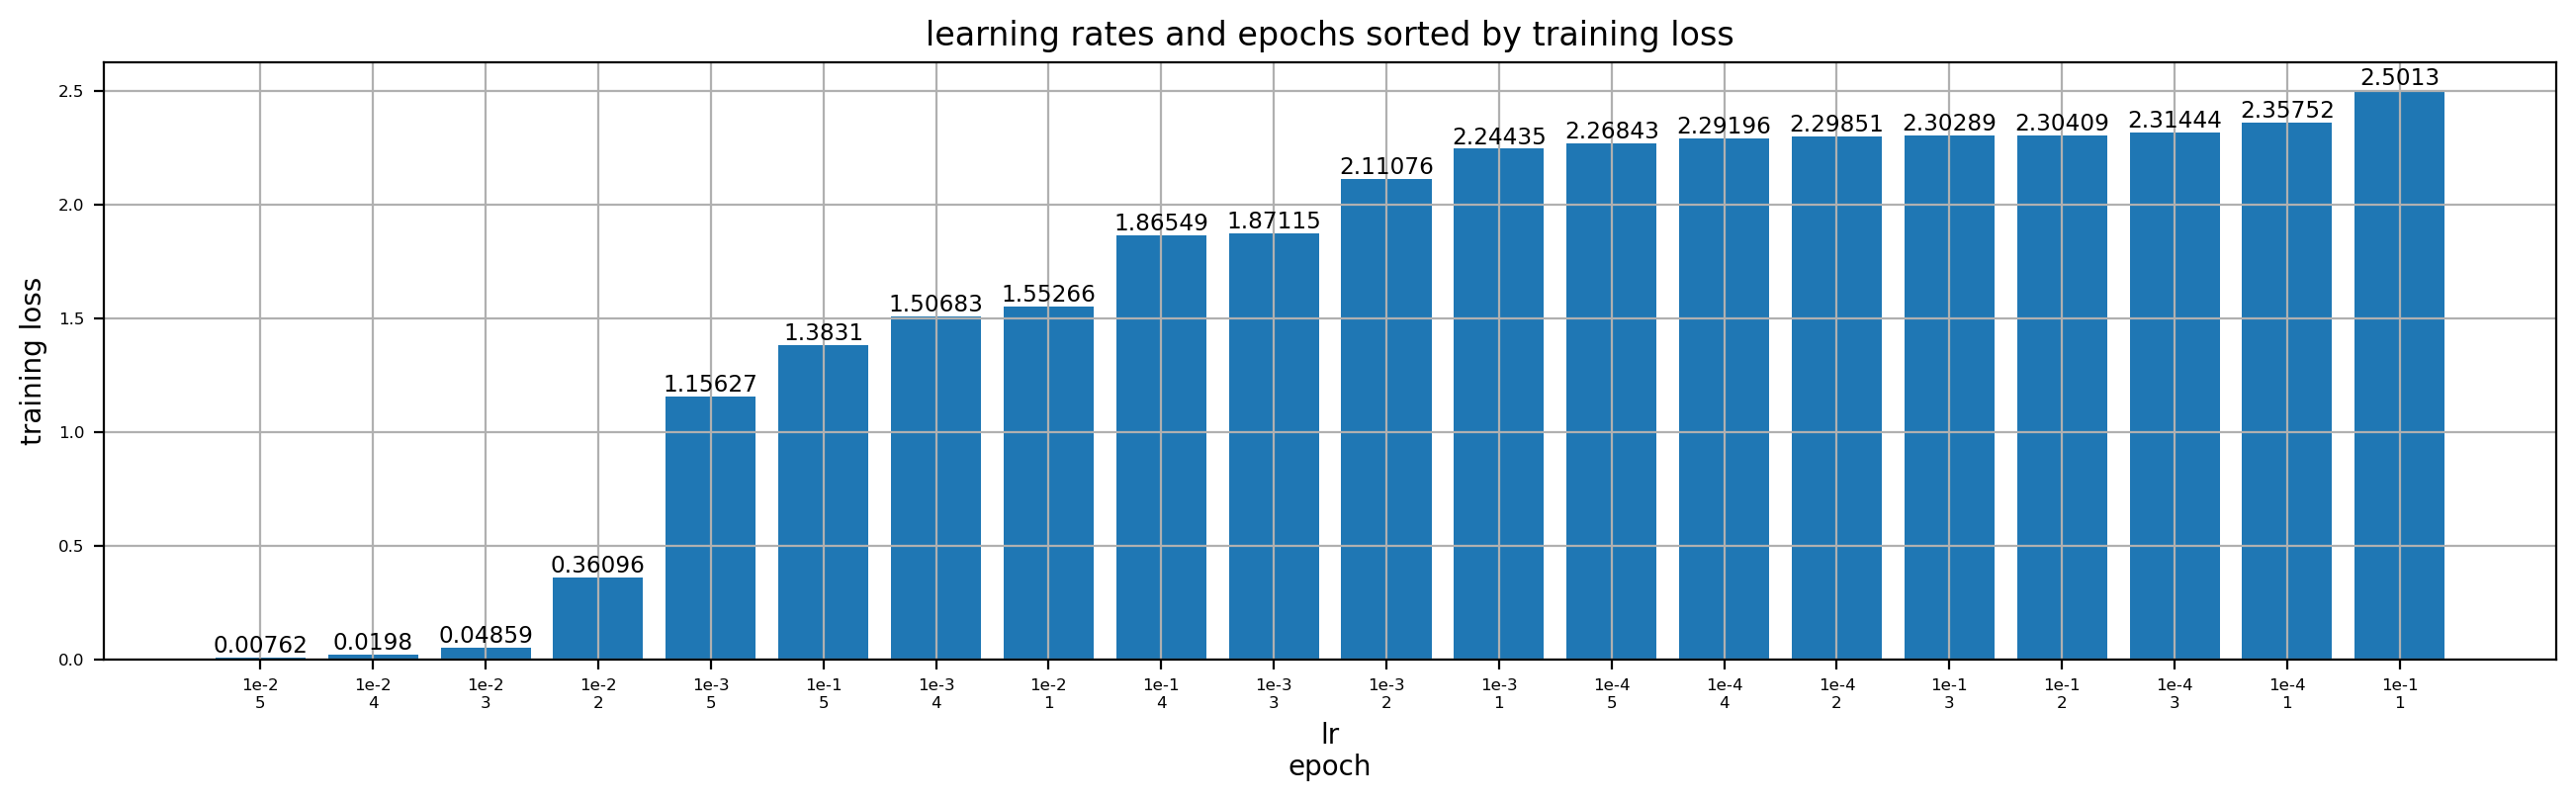

In [15]:
best_lr = utils.select_best_lr(results_ft, lrs, based_on = 'trn_loss', descending = False)

In [16]:
phase = 'finetuning phase 2'
lrs2 = utils.lrs_near_given(best_lr)
results_ft2 = lr_test(device, data_loader, epoch_num=20, lrs=lrs2, vgg_builder=vgg_builder, note=phase,save_epochs=True)

Created dir: runs/2022_04_29 21_07_18 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.05


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 21_10_21 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.03


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 21_13_25 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 21_16_34 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.0075


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 21_19_29 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.005


  0%|          | 0/20 [00:00<?, ?it/s]

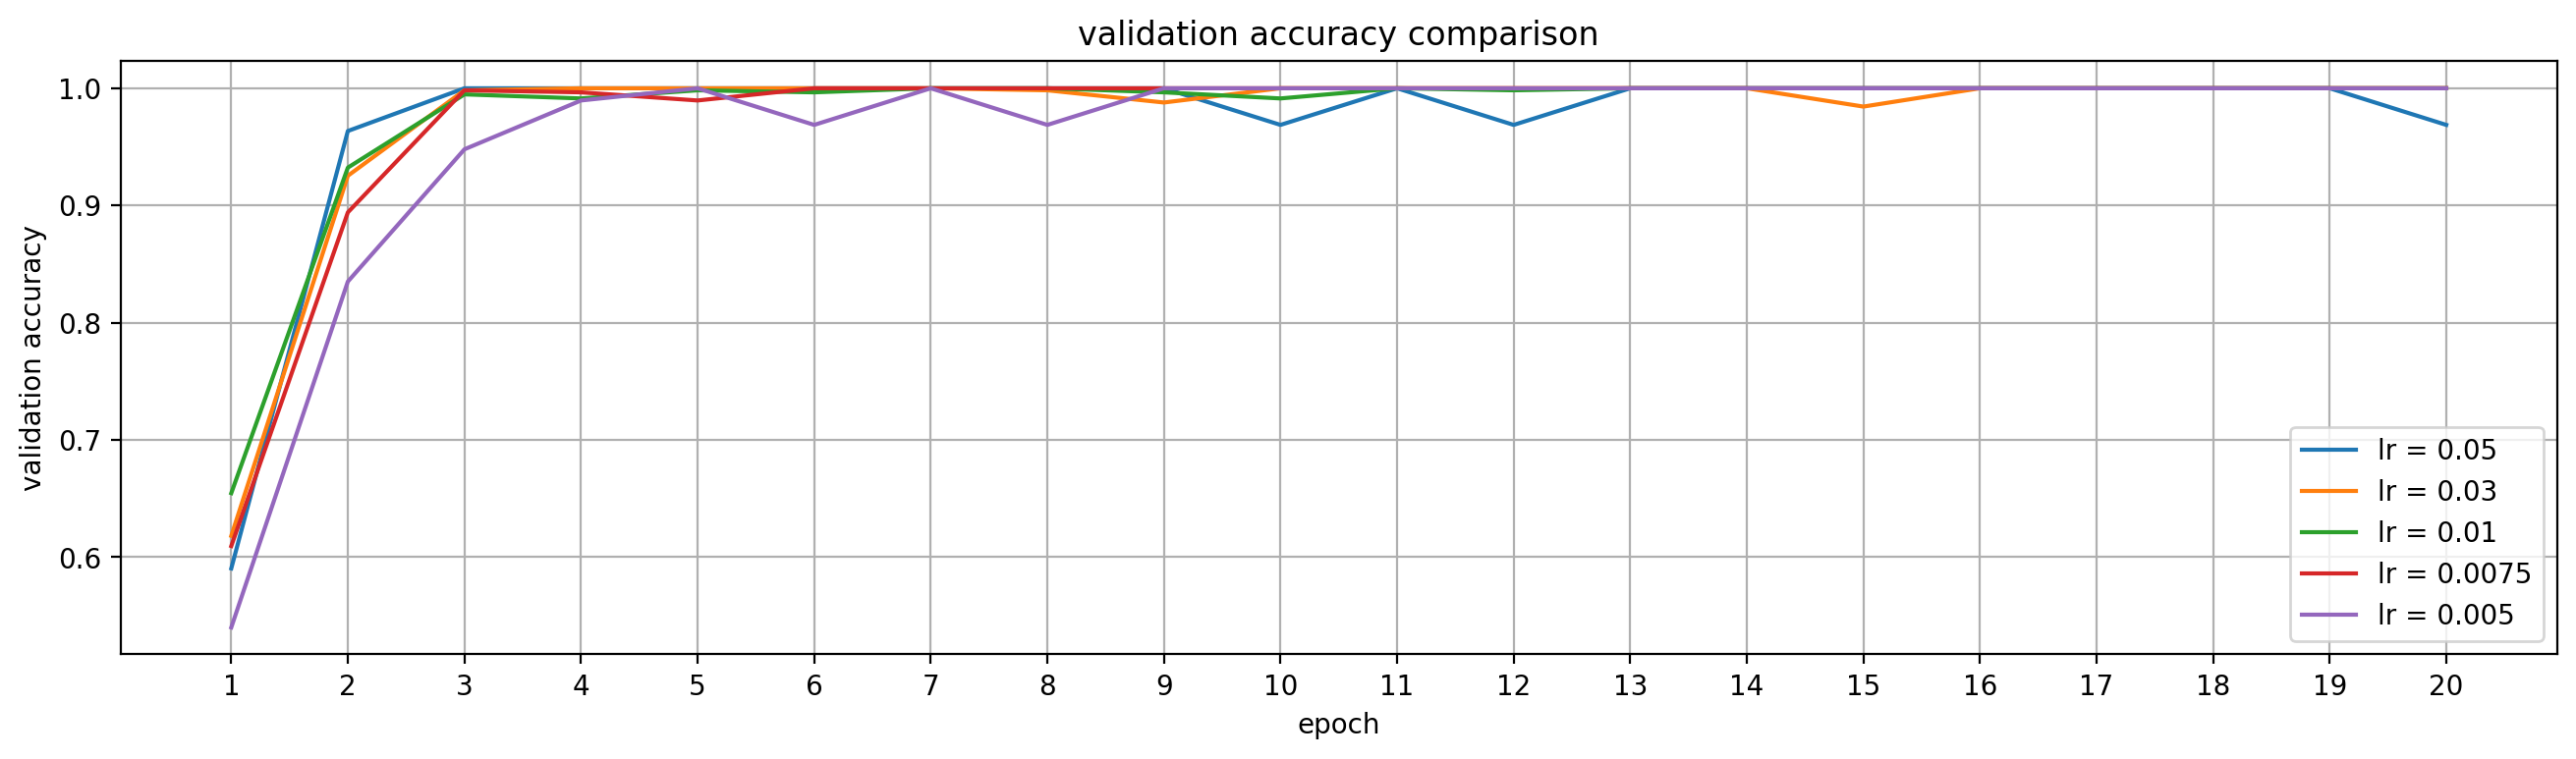

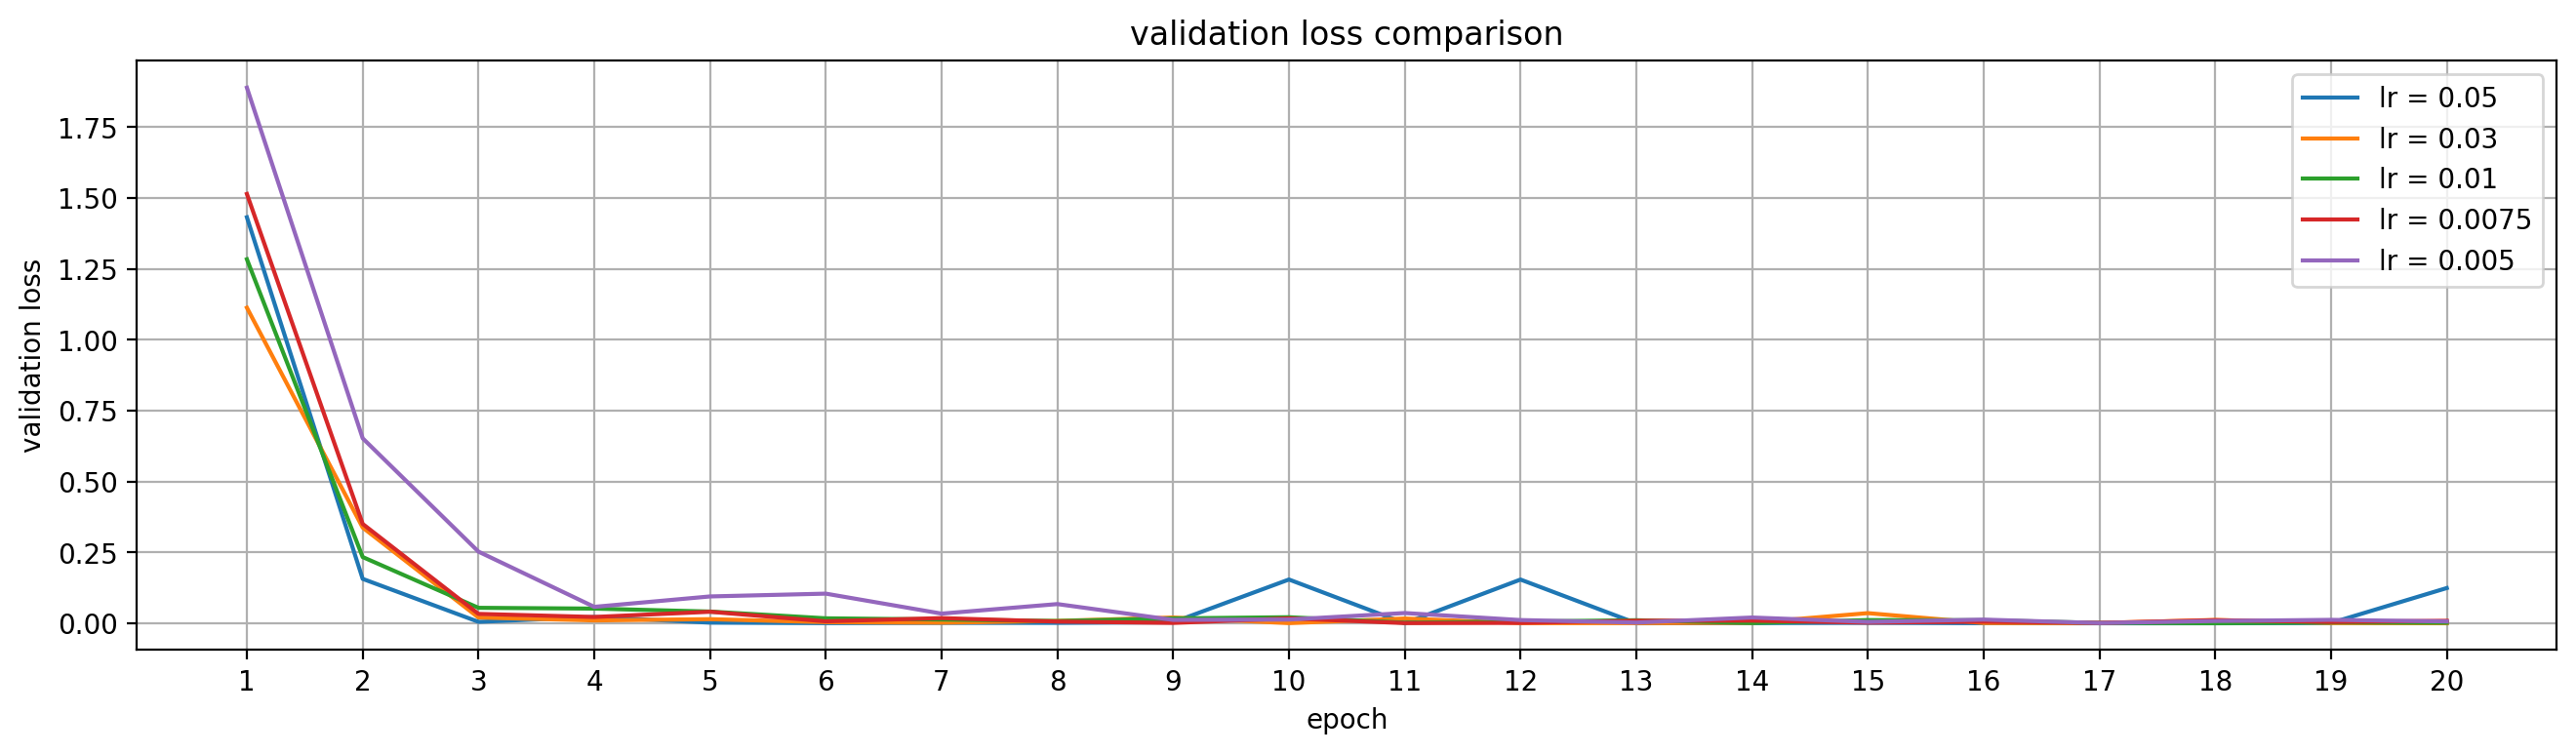

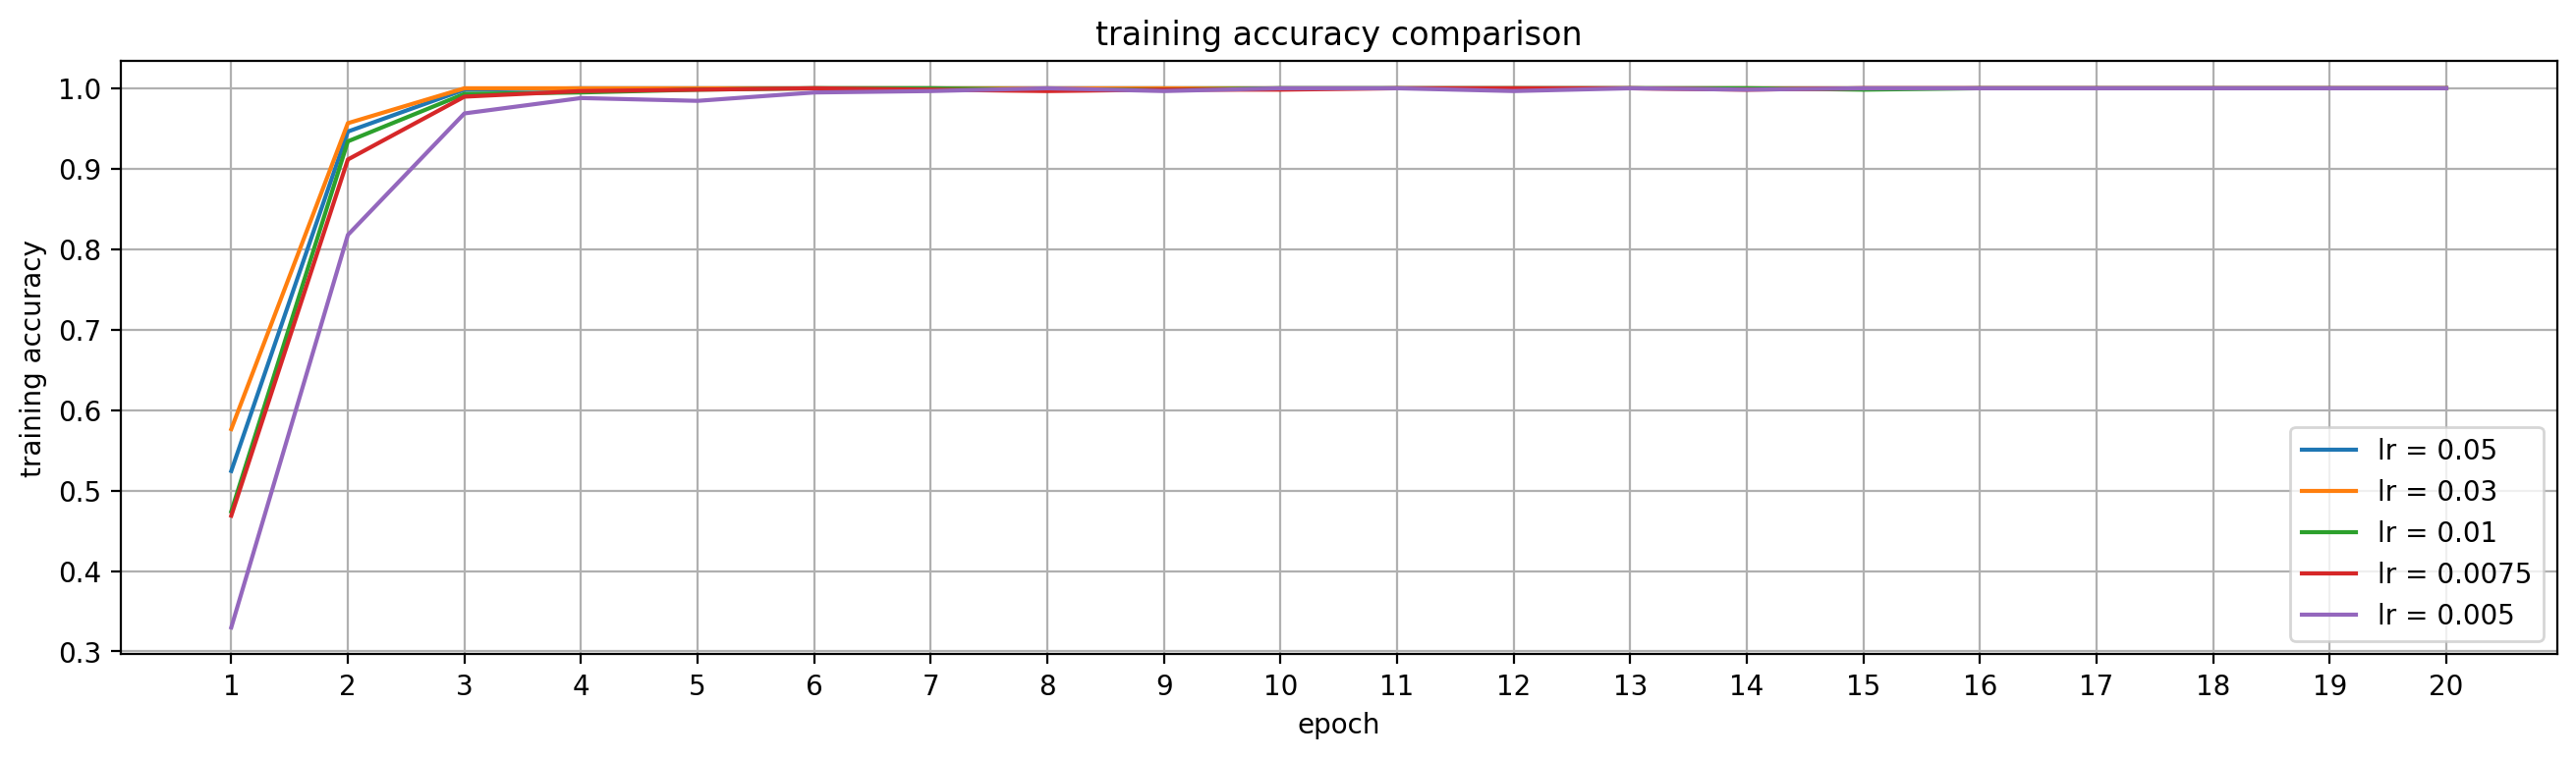

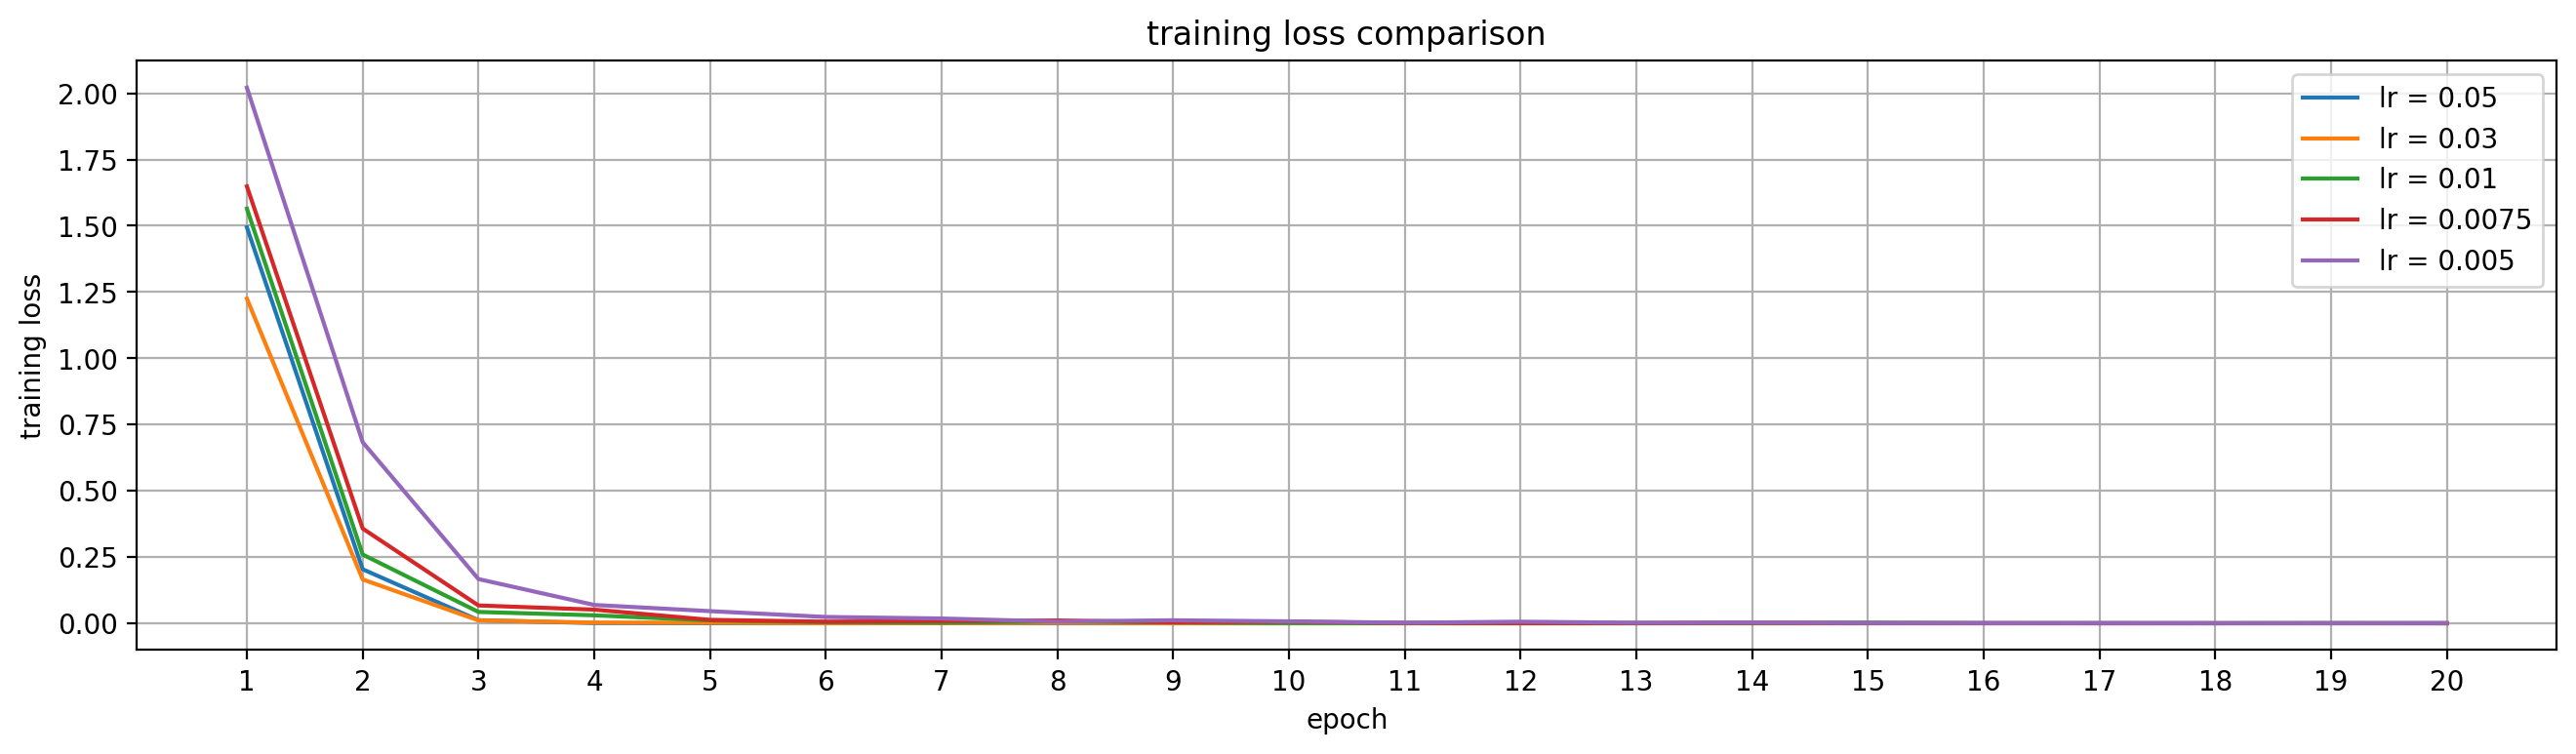

In [17]:
utils.display_results_compare(results_ft2, utils.lrs_to_str(lrs2))

In [18]:
filter_list = [phase, vgg_builder.classifier_str(), note]
test_results, headers = get_test_results(filter_list, data_loader, device, vgg_builder, first_n=10)
print(tabulate(test_results, headers=headers))

69/100 epochs has validation accuracy >= 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

  #    lr    epoch     val loss    val acc    test loss    test acc  model path
---  ----  -------  -----------  ---------  -----------  ----------  ------------------------------------------------------------------------------------------------
  1  0.05       17  1.22671e-05          1   0.0102689      0.99375  runs/2022_04_29 21_07_18 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.05/models/VGG_17.pt
  2  0.05       11  3.54121e-05          1   0.0261724      0.99375  runs/2022_04_29 21_07_18 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.05/models/VGG_11.pt
  3  0.05       18  3.97121e-05          1   0.0106415      0.99375  runs/2022_04_29 21_07_18 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.05/models/VGG_18.pt
  4  0.05       13  9.38578e-05          1   0.0316134      0.9875   runs/2022_04_29 21_07_18 VGG vgg11 classifier 1 finetuning phase 2 e=20 lr=0.05/models/VGG_13.pt
  5  0.03       20  0.000134286          1   0.0396688      0.99375  runs/2022_04_29 21_10

Finetuned model performs better.

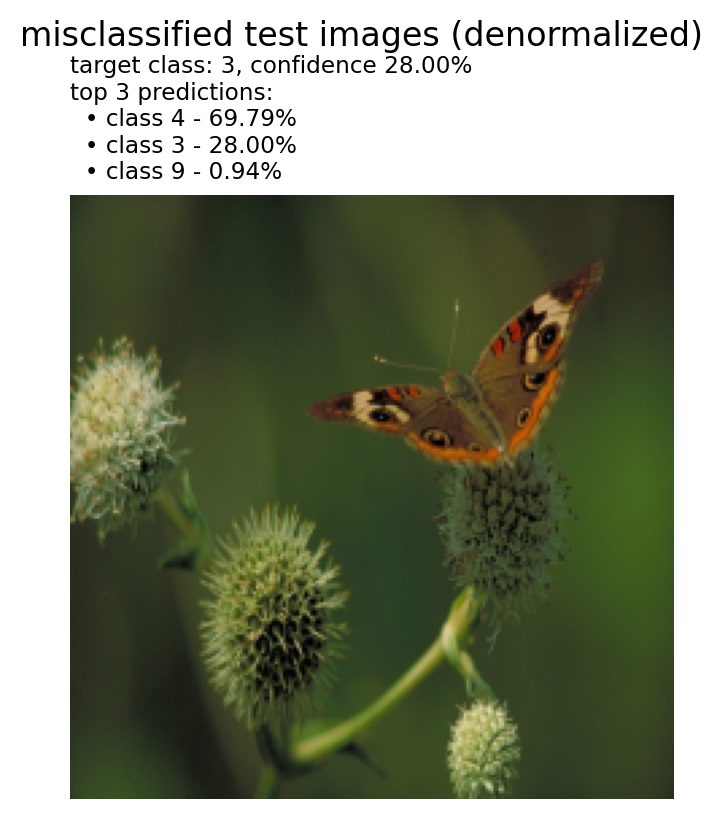

In [19]:
model = vgg_builder.build().to(device)
utils.load_state_to_network(device, test_results[0][-1], model)
utils.show_misclassified(model, device, data_loader.test_loader, test_mean, test_std, save_path='test_results/'+' '.join(filter_list))

# Part 4: finetuning with stochastic smoothing of the loss function

With the same leaning rates range as in Part 3, train the network with stochastic smoothing of the loss function.

Gaussian noise with $\sigma= 10^{-4} $ is applied to the copided network parameters, then gradient of copieed network is used to make a gradient descent step.

(See stochastic_smoothing() in finetuning.py, which is called before optimizer.step() in cnn_workflow/cnn_workflow.py train_single_batch() function)

In [13]:
phase = 'finetuning with stochastic smoothing'
results_ft3 = lr_test(device, data_loader, epoch_num=20, lrs=utils.lrs_near_given(0.01), vgg_builder=vgg_builder, note=phase,save_epochs=True, pre_step=stochastic_smoothing, pre_step_sigma=0.0001)

Created dir: runs/2022_04_29 22_21_36 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.05


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 22_25_05 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.03


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 22_28_33 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 22_32_02 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.0075


  0%|          | 0/20 [00:00<?, ?it/s]

Created dir: runs/2022_04_29 22_35_32 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.005


  0%|          | 0/20 [00:00<?, ?it/s]

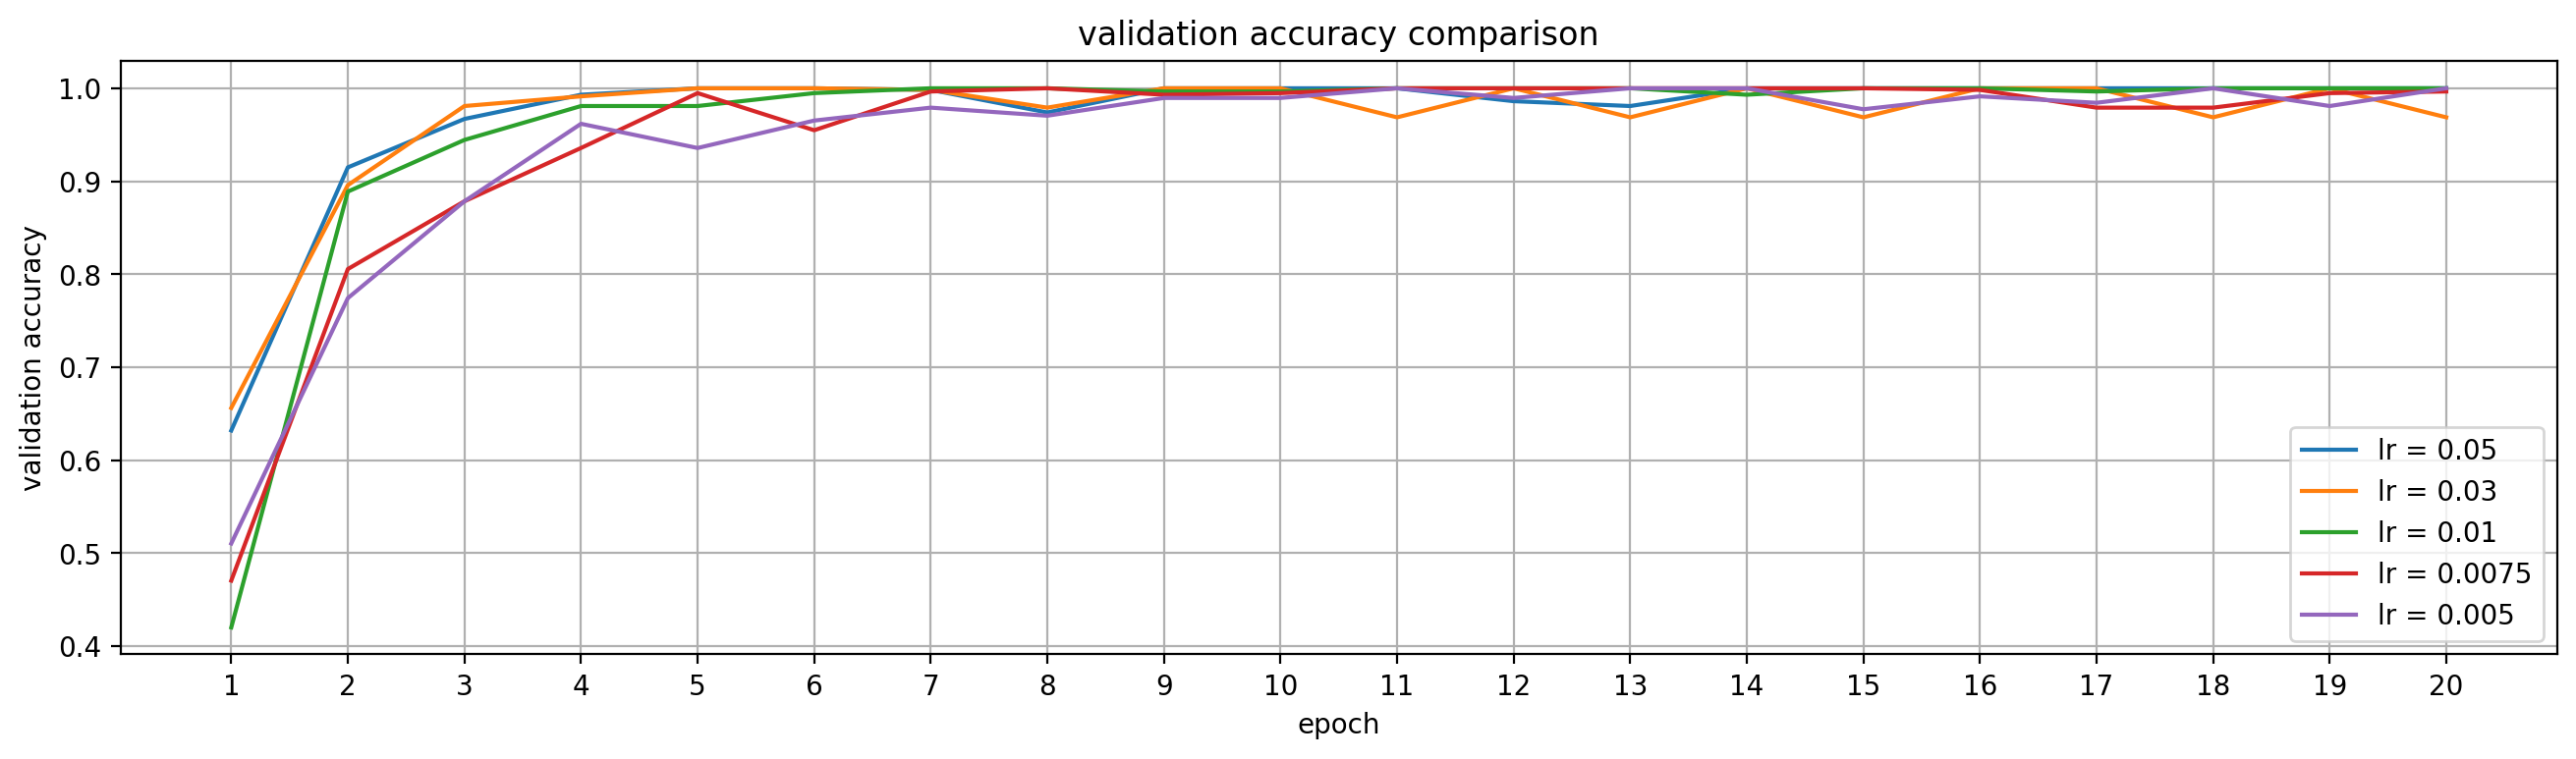

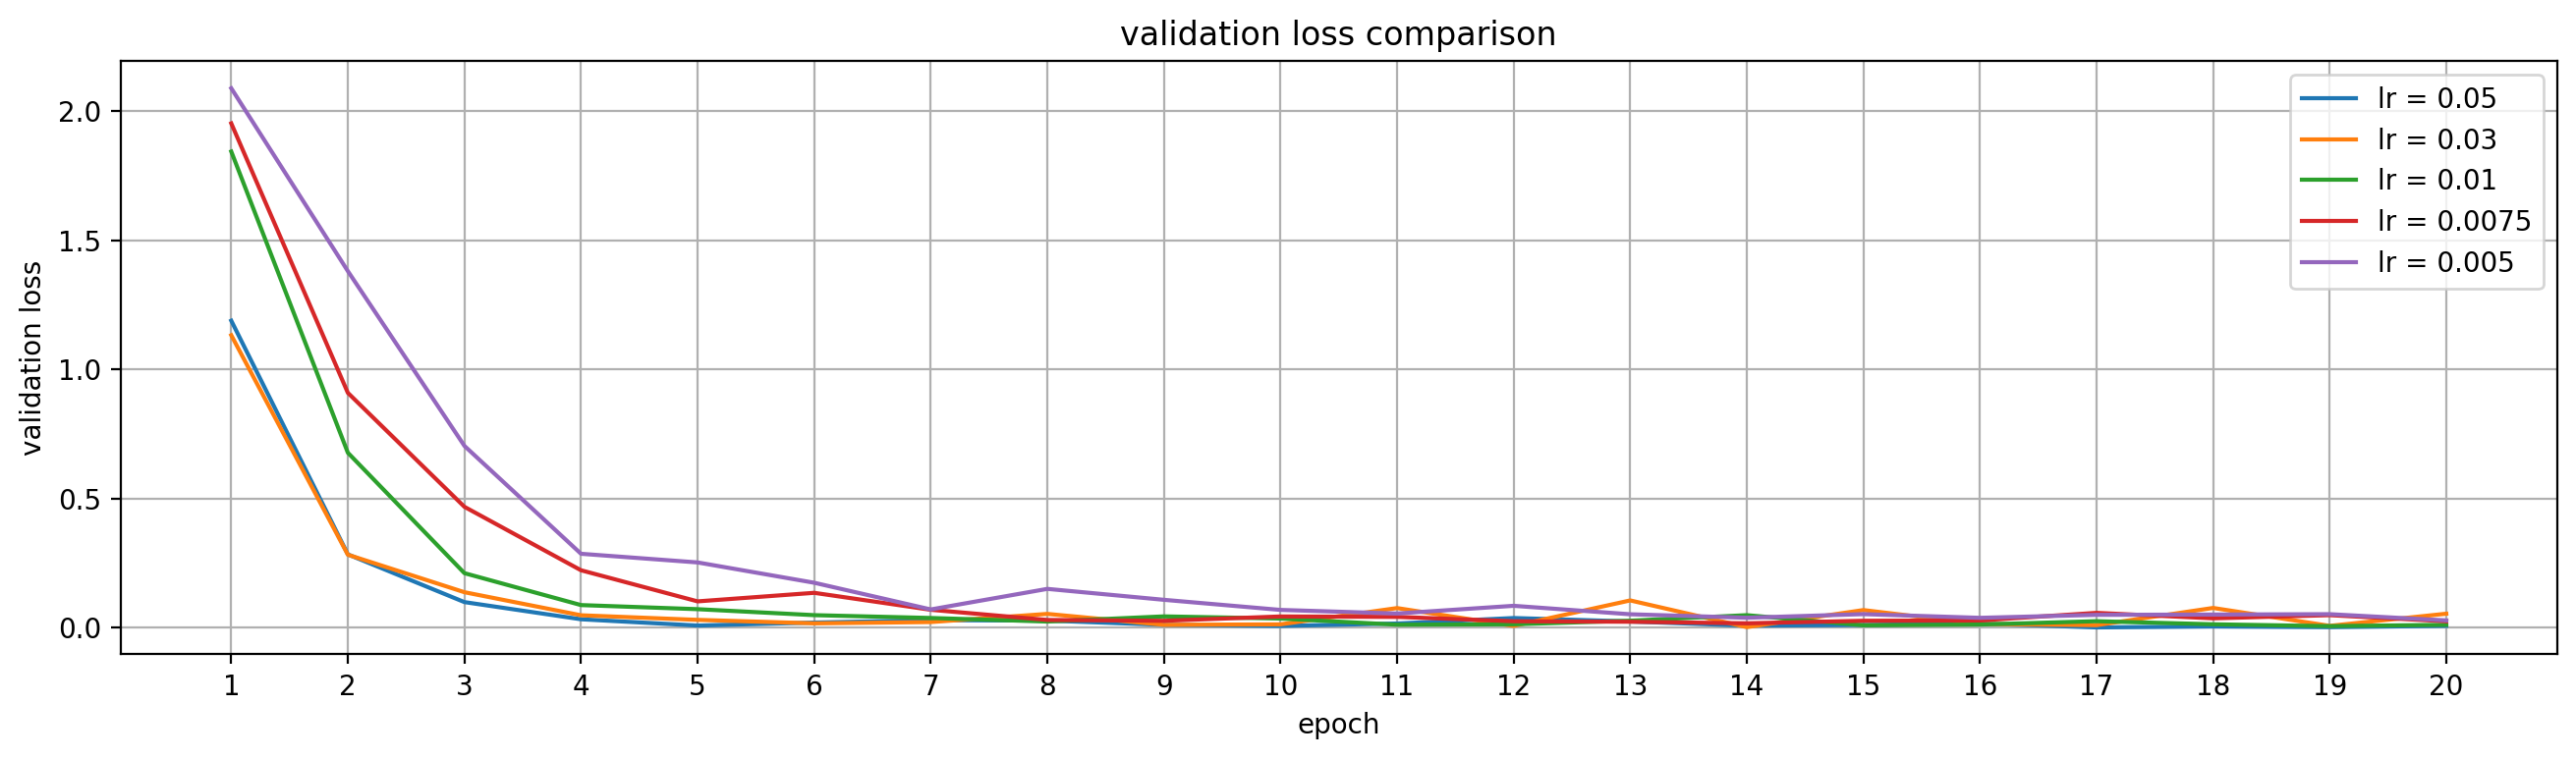

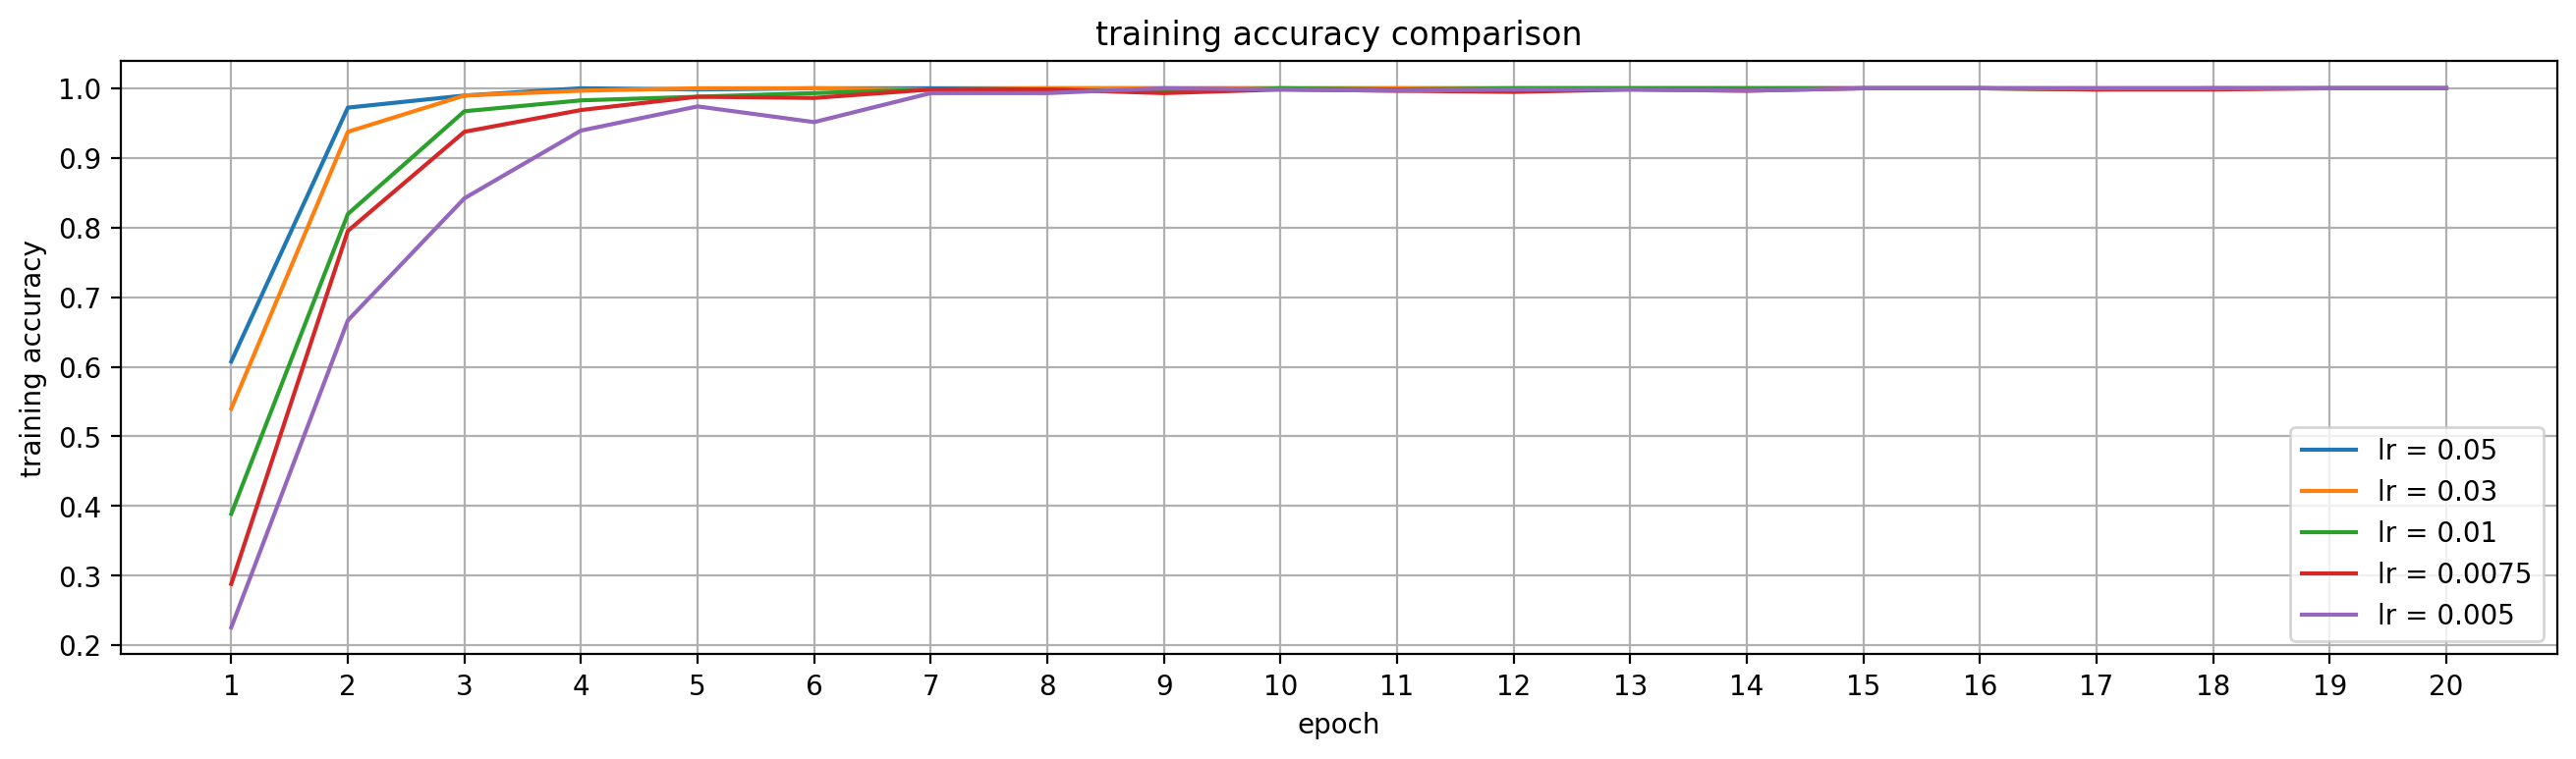

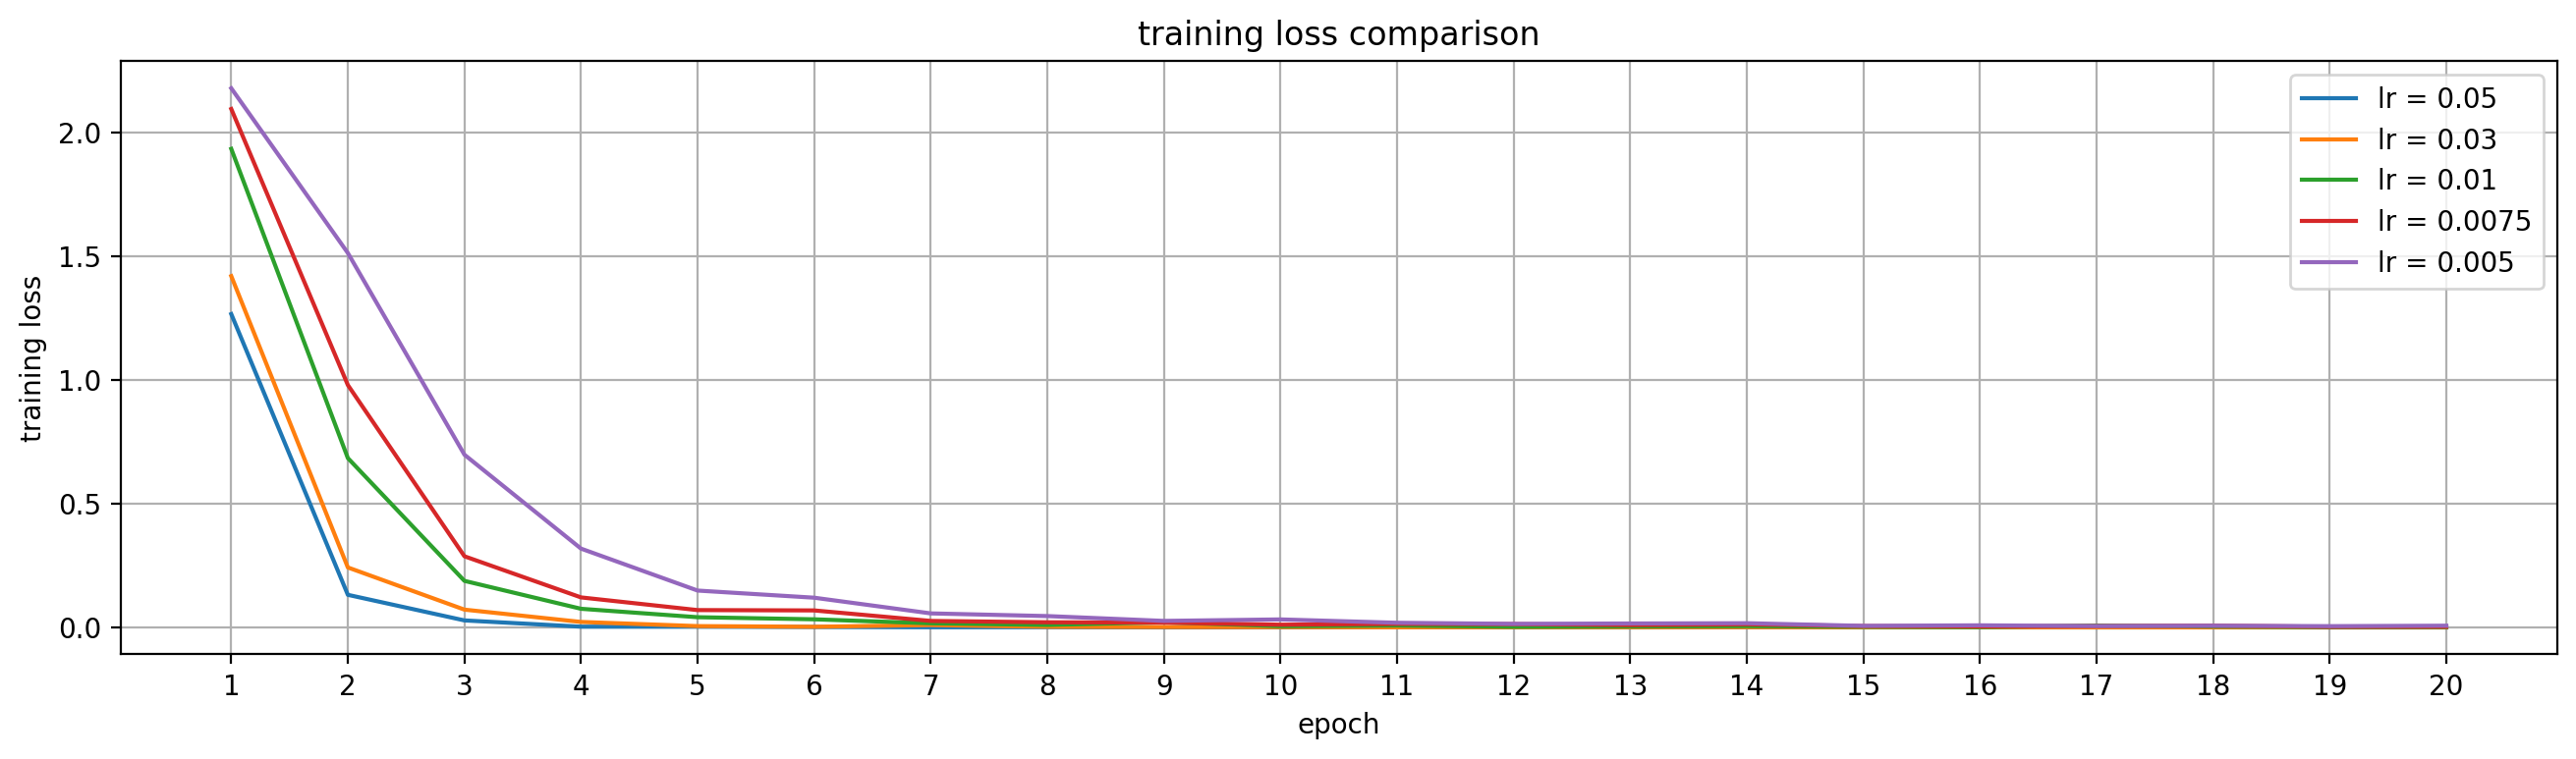

In [14]:
utils.display_results_compare(results_ft3, utils.lrs_to_str(utils.lrs_near_given(0.01)))

In [15]:
filter_list = [phase, vgg_builder.classifier_str(), note]
test_results, headers = get_test_results(filter_list, data_loader, device, vgg_builder, first_n=10)
print(tabulate(test_results, headers=headers))

42/100 epochs has validation accuracy >= 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

  #    lr    epoch     val loss    val acc    test loss    test acc  model path
---  ----  -------  -----------  ---------  -----------  ----------  ------------------------------------------------------------------------------------------------------------------
  1  0.05       17  0.000863656          1    0.0198101     0.99375  runs/2022_04_29 22_21_36 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.05/models/VGG_17.pt
  2  0.05       19  0.00181811           1    0.0192098     0.99375  runs/2022_04_29 22_21_36 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.05/models/VGG_19.pt
  3  0.03       14  0.00194788           1    0.0171534     0.99375  runs/2022_04_29 22_25_05 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.03/models/VGG_14.pt
  4  0.05       18  0.00448072           1    0.0188971     0.99375  runs/2022_04_29 22_21_36 VGG vgg11 classifier 1 finetuning with stochastic smoothing e=20 lr=0.05/models/VGG_18.pt


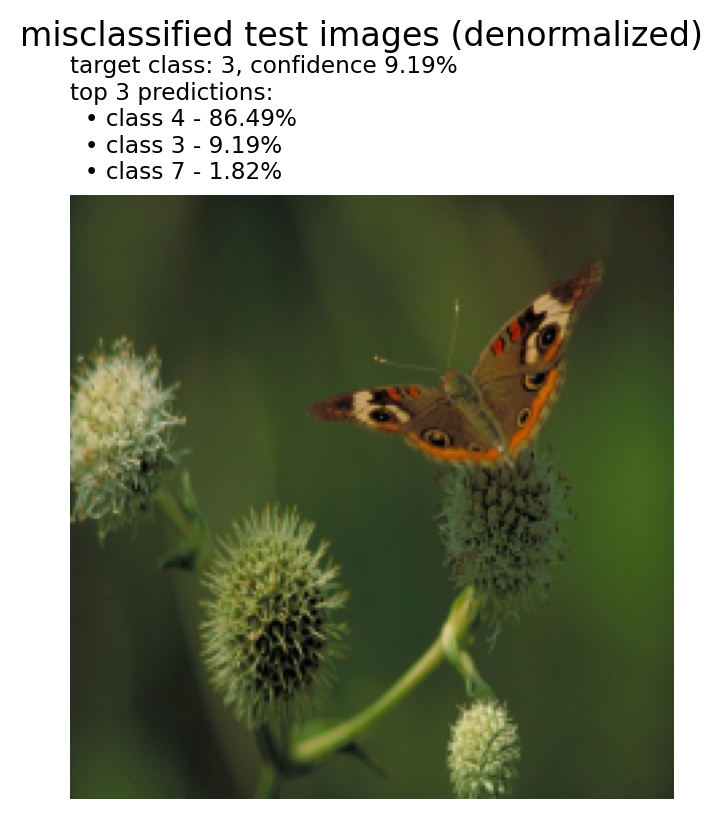

In [16]:
model = vgg_builder.build().to(device)
utils.load_state_to_network(device, test_results[0][-1], model)
utils.show_misclassified(model, device, data_loader.test_loader, test_mean, test_std, save_path='test_results/'+' '.join(filter_list))